### Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
dataset_location = "/Users/Xutao/Documents/CR4CR/dataset/"

In [3]:
df = pd.read_excel(dataset_location + "Market 00abc_240310.xlsx")

In [4]:
df['Administration'].unique()

array(['Spr 23', 'Fall 23', 'Spr 22', 'Fall 22'], dtype=object)

In [5]:
# Since there are some null responses will a score of 0, we want to replace them with empty strings
df.fillna("", inplace=True)

# select only the three responses columns and the score column
response_columns = ["Market.00a_OE", "Market.00bc_OE", "Market.00bc_OE follow up"]
score_column = ["Score"]
df = df[["Respondent Id", "Administration"] + response_columns + score_column]

In [6]:
def preprocess_text(text):
    # Lowercase the text
    # text = text.lower()

    text = re.sub(r'\n', ' ', text)
    #text = re.sub(r'^\w+\s*$', '',text)

    text = re.sub(r'[^a-zA-Z0-9\+\-\s]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    return text

def preprocess_text1(text):
    # Lowercase the text
    text = text.lower()

    # text = re.sub(r'\n', ' ', text)
    # Remove special characters
    #text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)

    # Strip leading and trailing whitespace
    text = text.strip()

    return text

# Preprocess the text in the response columns
for column in response_columns:
    df[column] = df[column].astype(str).apply(preprocess_text1)

### Create a MultiRoberta Model

In [7]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel
from torch import nn

class MultimodalRoberta(torch.nn.Module):
    def __init__(self, num_labels=5):
        super(MultimodalRoberta, self).__init__()
        self.num_labels = num_labels
        self.roberta1 = RobertaModel.from_pretrained('roberta-base')
        self.roberta2 = RobertaModel.from_pretrained('roberta-base')
        self.roberta3 = RobertaModel.from_pretrained('roberta-base')
        self.classifier = nn.Linear(self.roberta1.config.hidden_size + self.roberta2.config.hidden_size + self.roberta3.config.hidden_size, num_labels)

    def forward(self, input_ids_a, attention_mask_a, input_ids_b, attention_mask_b, input_ids_c, attention_mask_c):
        output_a = self.roberta1(input_ids=input_ids_a, attention_mask=attention_mask_a)
        output_b = self.roberta2(input_ids=input_ids_b, attention_mask=attention_mask_b)
        output_c = self.roberta3(input_ids=input_ids_c, attention_mask=attention_mask_c)

        concatenated_output = torch.cat((output_a.pooler_output, output_b.pooler_output, output_c.pooler_output), 1)

        return self.classifier(concatenated_output)
    

class MultimodalRobertaDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.columns = response_columns
        self.labels = self.dataframe['Score'].values

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        # Selecting sentence1 and sentence2 at the specified index in the data frame
        row = self.dataframe.iloc[index]
        response_a = row['Market.00a_OE']
        response_b = row['Market.00bc_OE']
        response_c = row['Market.00bc_OE follow up']
        score = row['Score']

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoding_a = self.tokenizer.encode_plus(response_a, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)
        encoding_b = self.tokenizer.encode_plus(response_b, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)
        encoding_c = self.tokenizer.encode_plus(response_c, add_special_tokens=True, max_length=self.max_length, padding='max_length', return_attention_mask=True, truncation=True)

        return {
            'input_ids_a': torch.tensor(encoding_a['input_ids'], dtype=torch.long),
            'attention_mask_a': torch.tensor(encoding_a['attention_mask'], dtype=torch.long),
            'input_ids_b': torch.tensor(encoding_b['input_ids'], dtype=torch.long),
            'attention_mask_b': torch.tensor(encoding_b['attention_mask'], dtype=torch.long),
            'input_ids_c': torch.tensor(encoding_c['input_ids'], dtype=torch.long),
            'attention_mask_c': torch.tensor(encoding_c['attention_mask'], dtype=torch.long),
            'score': torch.tensor(score, dtype=torch.float)
        }

In [8]:
def split_and_load_dataset(df, batch_size=8, val=False):

    tokenizer = RobertaTokenizer.from_pretrained('roberta-base', output_attentions=False)
    if val == False:
        train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Score'], random_state=42)
        
        train_dataset = MultimodalRobertaDataset(train_df, tokenizer)
        val_dataset = MultimodalRobertaDataset(val_df, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, None
    else:
        train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Score'], random_state=42)
        val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['Score'], random_state=42)

        train_dataset = MultimodalRobertaDataset(train_df, tokenizer)
        val_dataset = MultimodalRobertaDataset(val_df, tokenizer)
        test_dataset = MultimodalRobertaDataset(test_df, tokenizer)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        return train_loader, val_loader, test_loader
    
train_loader, val_loader, test_loader = split_and_load_dataset(df, batch_size=2, val=False)

In [9]:
def train(loss_fn, lr, EPOCH):
    model = MultimodalRoberta()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    model.train()
    for epoch in range(EPOCH):
        total_loss = 0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(
                batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
            )
            loss = loss_fn(outputs, batch['score'].to(device).long())
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print("Average training loss: {0:.2f}".format(avg_train_loss))

    return model

MultimodalRobertaModel = train(nn.CrossEntropyLoss(), 1e-5, 5)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.18
Average training loss: 0.67
Average training loss: 0.50
Average training loss: 0.31
Average training loss: 0.22


In [10]:
def evaluate(model, val_loader):
    model.eval()
    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            # Forward pass
            outputs = model(
                batch['input_ids_a'].to(device), batch['attention_mask_a'].to(device),
                batch['input_ids_b'].to(device), batch['attention_mask_b'].to(device),
                batch['input_ids_c'].to(device), batch['attention_mask_c'].to(device)
            )
            #all_predictions.extend(outputs.cpu().numpy())
            #all_labels.extend(batch['score'].numpy())

            _, outputs = torch.max(outputs, 1)
            all_predictions.extend(outputs.cpu().numpy())
            all_labels.extend(batch['score'].numpy())

    all_predictions = np.array(all_predictions).flatten()
    correct_predictions = sum(all_predictions == np.array(all_labels))
    total_predictions = len(all_predictions)
    test_accuracy = correct_predictions / total_predictions

    print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

    return test_accuracy, all_predictions

test_accuracy, all_predictions = evaluate(MultimodalRobertaModel, val_loader)

Test Accuracy: 65.00%


In [19]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Score'], random_state=42)
val_df['Predicted Score'] = all_predictions
val_df_inconsistent = val_df[val_df['Score'] != val_df['Predicted Score']]
## rank the order by index
val_df_inconsistent = val_df_inconsistent.sort_index()
val_df_inconsistent.to_excel(dataset_location + "val_df_inconsistent.xlsx")

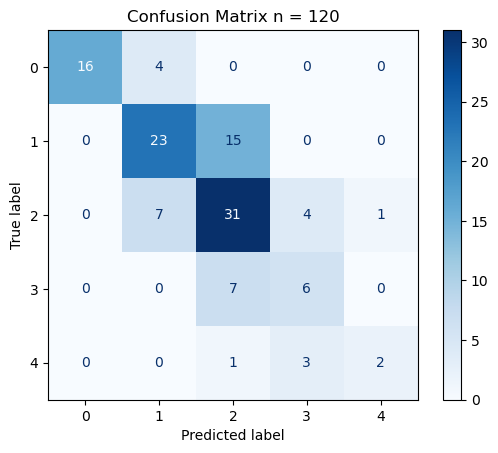

In [16]:
# draw the confusion matrix, do not use sns.heatmap, it will cause the error
## also show the rowsum and column sum on the plot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_df['Score'], val_df['Predicted Score'], labels=[0,1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix n = {len(val_df)}')
plt.show()

In [13]:
difference_amount = val_df_inconsistent['Administration'].value_counts()
total = val_df['Administration'].value_counts()
difference_amount = difference_amount / total
difference_amount

Administration
Spr 23     0.270833
Spr 22     0.433333
Fall 22    0.464286
Fall 23    0.214286
Name: count, dtype: float64

Text(0.5, 1.0, 'Score Distribution in Each Administration in test set')

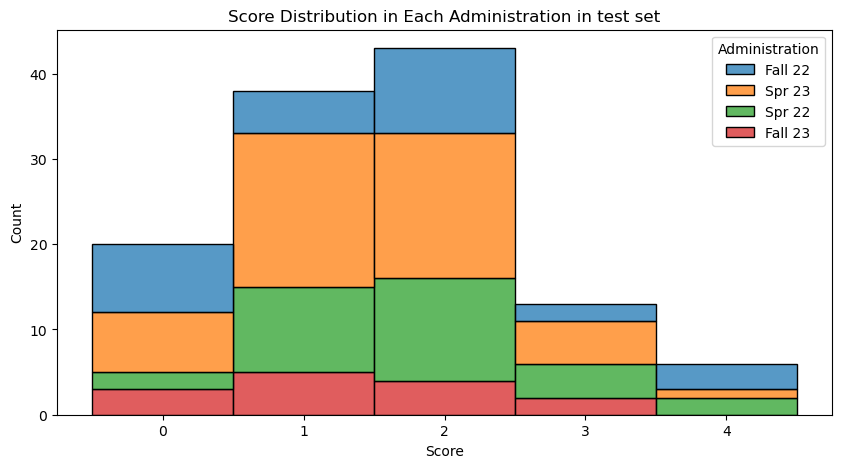

In [14]:
## Draw the histogram of val_df, with showing percentage of each score in each administration
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
#sns.histplot(val_df['Score'], kde = False, bins = 5, discrete=True, ax=ax, label='Train')
# show the percentage of each administration in each score
sns.histplot(data=val_df, x='Score', hue='Administration', multiple='stack', ax=ax, bins=5, discrete=True)
plt.title('Score Distribution in Each Administration in test set')

Text(0.5, 1.0, 'Score Distribution in Each Administration in train set')

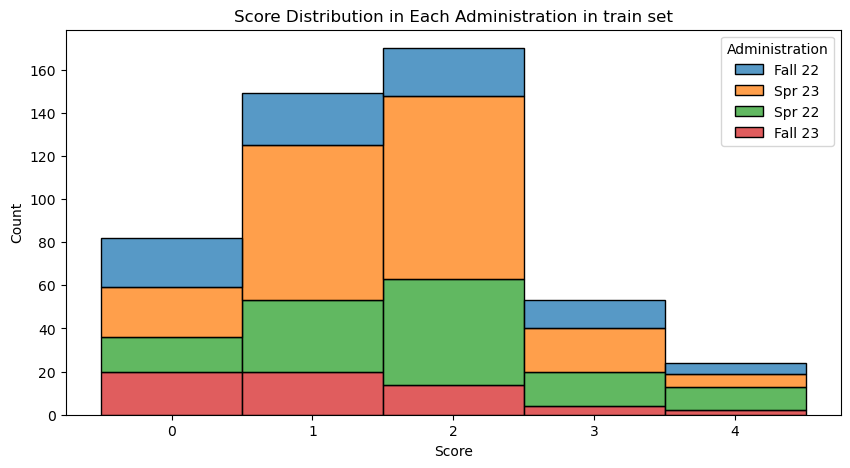

In [15]:
fix, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(data = train_df, x = 'Score', hue = 'Administration', multiple = 'stack', ax = ax, bins = 5, discrete = True)
plt.title('Score Distribution in Each Administration in train set')

In [132]:
torch.cuda.empty_cache()


In [45]:
learning_rates = [1e-5]  # List of learning rates to try
batch_sizes = [2, 4, 8, 16]  # List of batch sizes to try
epoch_sizes = [4,5,6,7,8,9,10]
combination_accuracies = {}


for epoch_size in epoch_sizes:
    for batch_size in batch_sizes:
        train_loader, val_loader, test_loader = split_and_load_dataset(df, batch_size=batch_size, val=False)
        model = train(nn.CrossEntropyLoss(), 1e-5, epoch_size)
        accuracy = evaluate(model, val_loader)
        combination_accuracies[(epoch_size, batch_size)] = accuracy
        torch.cuda.empty_cache()
        del model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.09
Average training loss: 0.71
Average training loss: 0.48
Average training loss: 0.31
Test Accuracy: 64.17%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.17
Average training loss: 0.70
Average training loss: 0.47
Average training loss: 0.32
Test Accuracy: 66.67%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.31
Average training loss: 0.79
Average training loss: 0.53
Average training loss: 0.40
Test Accuracy: 64.17%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.46
Average training loss: 0.99
Average training loss: 0.64
Average training loss: 0.46
Test Accuracy: 65.00%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.10
Average training loss: 0.68
Average training loss: 0.44
Average training loss: 0.27
Average training loss: 0.18
Test Accuracy: 70.00%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.21
Average training loss: 0.71
Average training loss: 0.48
Average training loss: 0.34
Average training loss: 0.19
Test Accuracy: 65.00%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.32
Average training loss: 0.82
Average training loss: 0.55
Average training loss: 0.37
Average training loss: 0.22
Test Accuracy: 65.83%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.46
Average training loss: 1.05
Average training loss: 0.69
Average training loss: 0.55
Average training loss: 0.42
Test Accuracy: 60.83%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.17
Average training loss: 0.73
Average training loss: 0.50
Average training loss: 0.28
Average training loss: 0.19
Average training loss: 0.12
Test Accuracy: 64.17%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.22
Average training loss: 0.74
Average training loss: 0.54
Average training loss: 0.37
Average training loss: 0.22
Average training loss: 0.13
Test Accuracy: 61.67%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.33
Average training loss: 0.80
Average training loss: 0.55
Average training loss: 0.39
Average training loss: 0.27
Average training loss: 0.17
Test Accuracy: 66.67%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.45
Average training loss: 1.00
Average training loss: 0.67
Average training loss: 0.49
Average training loss: 0.37
Average training loss: 0.28
Test Accuracy: 65.83%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.14
Average training loss: 0.66
Average training loss: 0.43
Average training loss: 0.29
Average training loss: 0.14
Average training loss: 0.09
Average training loss: 0.06
Test Accuracy: 65.83%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.21
Average training loss: 0.73
Average training loss: 0.51
Average training loss: 0.36
Average training loss: 0.25
Average training loss: 0.12
Average training loss: 0.08
Test Accuracy: 64.17%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.35
Average training loss: 0.83
Average training loss: 0.60
Average training loss: 0.35
Average training loss: 0.25
Average training loss: 0.16
Average training loss: 0.10
Test Accuracy: 67.50%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.44
Average training loss: 1.00
Average training loss: 0.70
Average training loss: 0.53
Average training loss: 0.41
Average training loss: 0.27
Average training loss: 0.16
Test Accuracy: 66.67%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.13
Average training loss: 0.73
Average training loss: 0.52
Average training loss: 0.32
Average training loss: 0.21
Average training loss: 0.13
Average training loss: 0.08
Average training loss: 0.02
Test Accuracy: 65.00%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.20
Average training loss: 0.71
Average training loss: 0.50
Average training loss: 0.31
Average training loss: 0.21
Average training loss: 0.11
Average training loss: 0.05
Average training loss: 0.04
Test Accuracy: 61.67%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.36
Average training loss: 0.82
Average training loss: 0.56
Average training loss: 0.38
Average training loss: 0.22
Average training loss: 0.17
Average training loss: 0.08
Average training loss: 0.04
Test Accuracy: 68.33%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.45
Average training loss: 1.00
Average training loss: 0.68
Average training loss: 0.51
Average training loss: 0.35
Average training loss: 0.23
Average training loss: 0.14
Average training loss: 0.09
Test Accuracy: 65.83%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.10
Average training loss: 0.65
Average training loss: 0.48
Average training loss: 0.33
Average training loss: 0.22
Average training loss: 0.08
Average training loss: 0.04
Average training loss: 0.02
Average training loss: 0.03
Test Accuracy: 65.83%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.24
Average training loss: 0.73
Average training loss: 0.50
Average training loss: 0.30
Average training loss: 0.16
Average training loss: 0.09
Average training loss: 0.05
Average training loss: 0.03
Average training loss: 0.03
Test Accuracy: 60.00%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.32
Average training loss: 0.74
Average training loss: 0.55
Average training loss: 0.40
Average training loss: 0.24
Average training loss: 0.16
Average training loss: 0.10
Average training loss: 0.06
Average training loss: 0.03
Test Accuracy: 65.83%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.43
Average training loss: 1.02
Average training loss: 0.70
Average training loss: 0.51
Average training loss: 0.31
Average training loss: 0.20
Average training loss: 0.11
Average training loss: 0.07
Average training loss: 0.05
Test Accuracy: 57.50%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.14
Average training loss: 0.69
Average training loss: 0.44
Average training loss: 0.26
Average training loss: 0.16
Average training loss: 0.10
Average training loss: 0.03
Average training loss: 0.02
Average training loss: 0.01
Average training loss: 0.01
Test Accuracy: 67.50%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.19
Average training loss: 0.72
Average training loss: 0.48
Average training loss: 0.32
Average training loss: 0.19
Average training loss: 0.09
Average training loss: 0.08
Average training loss: 0.03
Average training loss: 0.02
Average training loss: 0.01
Test Accuracy: 65.00%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.30
Average training loss: 0.77
Average training loss: 0.55
Average training loss: 0.36
Average training loss: 0.22
Average training loss: 0.12
Average training loss: 0.06
Average training loss: 0.04
Average training loss: 0.02
Average training loss: 0.02
Test Accuracy: 68.33%


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average training loss: 1.47
Average training loss: 1.05
Average training loss: 0.72
Average training loss: 0.53
Average training loss: 0.37
Average training loss: 0.25
Average training loss: 0.14
Average training loss: 0.08
Average training loss: 0.06
Average training loss: 0.04
Test Accuracy: 63.33%


In [47]:
combination_accuracies

{(4, 2): 0.6416666666666667,
 (4, 4): 0.6666666666666666,
 (4, 8): 0.6416666666666667,
 (4, 16): 0.65,
 (5, 2): 0.7,
 (5, 4): 0.65,
 (5, 8): 0.6583333333333333,
 (5, 16): 0.6083333333333333,
 (6, 2): 0.6416666666666667,
 (6, 4): 0.6166666666666667,
 (6, 8): 0.6666666666666666,
 (6, 16): 0.6583333333333333,
 (7, 2): 0.6583333333333333,
 (7, 4): 0.6416666666666667,
 (7, 8): 0.675,
 (7, 16): 0.6666666666666666,
 (8, 2): 0.65,
 (8, 4): 0.6166666666666667,
 (8, 8): 0.6833333333333333,
 (8, 16): 0.6583333333333333,
 (9, 2): 0.6583333333333333,
 (9, 4): 0.6,
 (9, 8): 0.6583333333333333,
 (9, 16): 0.575,
 (10, 2): 0.675,
 (10, 4): 0.65,
 (10, 8): 0.6833333333333333,
 (10, 16): 0.6333333333333333}